# 1- Import data and required libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import os
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import the last updated merged data frame
path = r'/Users/gomula/Documents/Instacart Basket Analysis 14.05.2023'
df_merged = pd.read_pickle(os.path.join(path, 'Data','Prepared Data', 'final_merged.pkl'))
df_merged.head()



,user_id,first_name,last_name,gender,state,age,date_joined,number_of_dependants,family_status,income,...,price_range_loc,busiest_day,busiest_days,busiest_period_of_day,max_order,loyalty_flag,mean_prder_price,spending_flag,order_frequency,frequency_flag
0,26711,Deborah,Esquivel,Female,Missouri,48,1/1/2017,3,married,165665,...,Mid-range product,Regularly busy,Busiest days,Most orders,8,New_customer,7.988889,Low spender,19.0,Regular customer
1,26711,Deborah,Esquivel,Female,Missouri,48,1/1/2017,3,married,165665,...,Mid-range product,Regularly busy,Regularly busy,Most orders,8,New_customer,7.988889,Low spender,19.0,Regular customer
2,26711,Deborah,Esquivel,Female,Missouri,48,1/1/2017,3,married,165665,...,Mid-range product,Regularly busy,Busiest days,Most orders,8,New_customer,7.988889,Low spender,19.0,Regular customer
3,26711,Deborah,Esquivel,Female,Missouri,48,1/1/2017,3,married,165665,...,Mid-range product,Regularly busy,Regularly busy,Most orders,8,New_customer,7.988889,Low spender,19.0,Regular customer
4,26711,Deborah,Esquivel,Female,Missouri,48,1/1/2017,3,married,165665,...,Mid-range product,Regularly busy,Slowest days,Most orders,8,New_customer,7.988889,Low spender,19.0,Regular customer


In [3]:
print('df_merged size: ',df_merged.shape)

df_merged size:  (32404859, 34)


# 2- Check for PII

In [4]:
# for this part we extract the column names to see if there is any personal information 
df_merged.columns

Index(['user_id', 'first_name', 'last_name', 'gender', 'state', 'age',
       'date_joined', 'number_of_dependants', 'family_status', 'income',
       'order_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'prices', '_merge', 'price_range_loc', 'busiest_day',
       'busiest_days', 'busiest_period_of_day', 'max_order', 'loyalty_flag',
       'mean_prder_price', 'spending_flag', 'order_frequency',
       'frequency_flag'],
      dtype='object')

###### It seems that just 'first_name' and 'last_name' can be considered as PII. Therefore we've decided to drop these two columns as they are not critical information for our analysis and we can simply go on with 'user_id'

In [5]:
# drop 'first_name' and 'last_name'
df_merged.drop(columns=['first_name', 'last_name'], inplace=True)

In [6]:
df_merged.shape

(32404859, 32)

# 3- Determine whether there’s a difference in spending habits between the different U.S. regions.

In [7]:
# define US regions using for loop
Northeast_region =  ['Maine', 'New Hampshire', 'Vermont','Massachusetts', 'Rhode Island',
                     'Connecticut', 'New York', 'Pennsylvania', 'New Jersey']
Midwest_region = ['Wisconsin', 'Michigan', 'Illinois', 'Indiana','Ohio', 'North Dakota', 
                  'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri']
South_region = ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia',
                'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 
                'Mississippi', 'Alabama','Oklahoma', 'Texas', 'Arkansas', 'Louisiana']
West_region = ['Idaho','Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico',
              'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']
region = []
for st in df_merged['state']:
    if st in Northeast_region:
        region.append('Northeast_region') 
    elif st in Midwest_region:
        region.append('Midwest_region')
    elif st in West_region:
        region.append('West_region')
    else:
        region.append('South_region')
        
df_merged['region'] = region

In [8]:
# check the frequency of regions
df_merged['region'].value_counts()

South_region        10791885
West_region          8292913
Midwest_region       7597325
Northeast_region     5722736
Name: region, dtype: int64

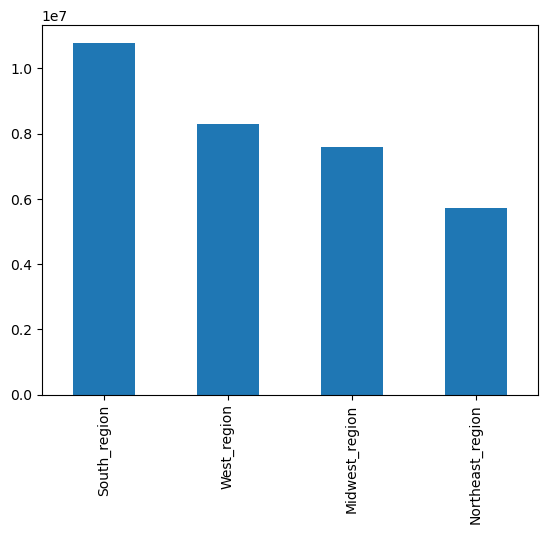

In [9]:
# plot the frequency of orders among regions
region = df_merged['region'].value_counts().plot.bar()

In [10]:
# save plot
region.figure.savefig(os.path.join(path, 'Analysis', 'region_freq.png'))

In [11]:
# investigate the relation between 'region' and 'spending_flag'
cross_region_spending = pd.crosstab(df_merged['region'], df_merged['spending_flag'], dropna=False)
cross_region_spending

spending_flag,High spender,Low spender
region,,
Midwest_region,155975,7441350
Northeast_region,108225,5614511
South_region,209691,10582194
West_region,160354,8132559


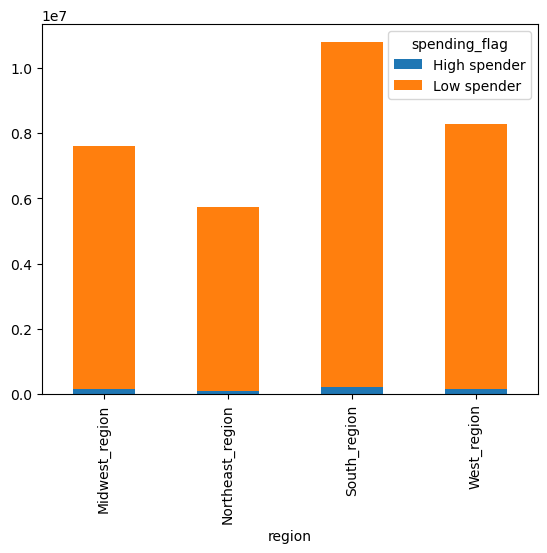

In [12]:
Spending_by_region = cross_region_spending.plot(kind='bar', stacked = True)

In [13]:
# exporting grapg
Spending_by_region.figure.savefig(os.path.join(path, 'Analysis', 'region_spending_flag.png'))

### These table and graph suggests that we have the highest orders in 'South_region' and then in 'West_region'. The number of High_spender are also is larger in 'South_region' and then in 'West_region'.

# 4- Exclude the low activity customers from the dataframe

In [14]:
# create flag for low_activity and high_activity customers
df_merged.loc[df_merged['max_order']<5, 'activity_flag'] = 'Low_activity'
df_merged.loc[df_merged['max_order']>=5, 'activity_flag'] = 'High_activity'
df_merged['activity_flag'].value_counts()



High_activity    30964564
Low_activity      1440295
Name: activity_flag, dtype: int64

In [15]:
# extract data set for low_activity customers
df_low_activity = df_merged[df_merged['activity_flag'] == 'Low_activity']
df_low_activity['max_order'].value_counts()

4    753543
3    686741
2         6
1         5
Name: max_order, dtype: int64

In [16]:
# extract data set high_activity customers
df_high_activity = df_merged[df_merged['activity_flag'] == 'High_activity']
df_high_activity['max_order'].value_counts()

99    1171333
8      811843
6      811396
9      810213
7      803979
       ...   
93      50333
90      48328
97      44949
98      44587
96      40453
Name: max_order, Length: 95, dtype: int64

In [17]:
# import current created dataframes
df_merged.to_pickle(os.path.join(path, 'Data','Prepared Data', 'final_mergedv2.pkl'))
df_low_activity.to_pickle(os.path.join(path, 'Data','Prepared Data', 'low_activity.pkl'))
df_high_activity.to_pickle(os.path.join(path, 'Data','Prepared Data', 'high_activity.pkl'))

In [18]:
del df_high_activity

In [19]:
del df_low_activity

# 5- Create customer profiles

# ####Based on age¶

In [20]:
# determine the age interval of customers
min_age = df_merged['age'].min()
max_age = df_merged['age'].max()
print('minimum age is: ', min_age)
print('maximum age is: ', max_age)


minimum age is:  18
maximum age is:  81


In [21]:
# we categorize the age groups as 10years interval from <20 to >80
age_group = []
for i in df_merged['age']:
    if (i<20) :
        age_group.append('<20')
    elif (i>=20) and (i<30):
        age_group.append('20-30')
    elif (i>=30) and (i<40):
        age_group.append('30-40')
    elif (i>=40) and (i<50):
        age_group.append('40-50')
    elif (i>=50) and (i<60):
        age_group.append('50-60')
    elif (i>=60) and (i<70):
        age_group.append('60-70')
    elif (i>=70) and (i<80):
        age_group.append('70-80')
    else:
        age_group.append('>80')
df_merged['age_group'] = age_group

In [22]:
df_merged.head(20)

,user_id,gender,state,age,date_joined,number_of_dependants,family_status,income,order_id,eval_set,...,busiest_period_of_day,max_order,loyalty_flag,mean_prder_price,spending_flag,order_frequency,frequency_flag,region,activity_flag,age_group
0,26711,Female,Missouri,48,1/1/2017,3,married,165665,2543867,prior,...,Most orders,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50
1,26711,Female,Missouri,48,1/1/2017,3,married,165665,1285508,prior,...,Most orders,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50
2,26711,Female,Missouri,48,1/1/2017,3,married,165665,2578584,prior,...,Most orders,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50
3,26711,Female,Missouri,48,1/1/2017,3,married,165665,423547,prior,...,Most orders,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50
4,26711,Female,Missouri,48,1/1/2017,3,married,165665,2524893,prior,...,Most orders,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50
5,26711,Female,Missouri,48,1/1/2017,3,married,165665,2984525,prior,...,Average orders,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50
6,26711,Female,Missouri,48,1/1/2017,3,married,165665,2505178,prior,...,Average orders,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50
7,26711,Female,Missouri,48,1/1/2017,3,married,165665,1285508,prior,...,Most orders,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50
8,26711,Female,Missouri,48,1/1/2017,3,married,165665,2578584,prior,...,Most orders,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50
9,26711,Female,Missouri,48,1/1/2017,3,married,165665,518967,prior,...,Most orders,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50


# Based on income


In [23]:
# determine the income interval of customers
min_income = df_merged['income'].min()
max_income = df_merged['income'].max()
print('minimum income is: ', min_income)
print('maximum income is: ', max_income)

minimum income is:  25903
maximum income is:  593901


In [24]:
# we categorize the income groups as following
income_group = []
for i in df_merged['income']:
    if (i<25000) :
        income_group.append('<25k')
    elif (i>=25000) and (i<50000):
        income_group.append('25k-50k')
    elif (i>=50000) and (i<75000):
        income_group.append('50k-75k')
    elif (i>=75000) and (i<100000):
        income_group.append('75k-100k')
    elif (i>=100000) and (i<125000):
        income_group.append('100k-125k')
    elif (i>=125000) and (i<150000):
        income_group.append('125k-150k')
    elif (i>=150000) and (i<175000):
        income_group.append('150k-175k')
    elif (i>=175000) and (i<200000):
        income_group.append('175k-200k')
    else:
        income_group.append('>200k')
df_merged['income_group'] = income_group

In [25]:
df_merged.head(20)

,user_id,gender,state,age,date_joined,number_of_dependants,family_status,income,order_id,eval_set,...,max_order,loyalty_flag,mean_prder_price,spending_flag,order_frequency,frequency_flag,region,activity_flag,age_group,income_group
0,26711,Female,Missouri,48,1/1/2017,3,married,165665,2543867,prior,...,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k
1,26711,Female,Missouri,48,1/1/2017,3,married,165665,1285508,prior,...,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k
2,26711,Female,Missouri,48,1/1/2017,3,married,165665,2578584,prior,...,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k
3,26711,Female,Missouri,48,1/1/2017,3,married,165665,423547,prior,...,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k
4,26711,Female,Missouri,48,1/1/2017,3,married,165665,2524893,prior,...,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k
5,26711,Female,Missouri,48,1/1/2017,3,married,165665,2984525,prior,...,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k
6,26711,Female,Missouri,48,1/1/2017,3,married,165665,2505178,prior,...,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k
7,26711,Female,Missouri,48,1/1/2017,3,married,165665,1285508,prior,...,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k
8,26711,Female,Missouri,48,1/1/2017,3,married,165665,2578584,prior,...,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k
9,26711,Female,Missouri,48,1/1/2017,3,married,165665,518967,prior,...,8,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k


# ### Based on Goods categories

In [26]:
# as we have the 'department id' and the related name of each department we can add goods categories as bellow:
goods_group = []
for i in df_merged['department_id']:
    if i == 1:
        goods_group.append('Frozen')
    elif i == 2:
        goods_group.append('Other')
    elif i == 3:
        goods_group.append('Bakery')
    elif i == 4:
        goods_group.append('Produce')
    elif i == 5:
        goods_group.append('Alcohol')
    elif i == 6:
        goods_group.append('International')
    elif i == 7:
        goods_group.append('Beverages')
    elif i == 8:
        goods_group.append('Pets')
    elif i == 9:
        goods_group.append('Dry goods pasta')
    elif i == 10:
        goods_group.append('Bulk')
    elif i == 11:
        goods_group.append('Personal care')
    elif i == 12:
        goods_group.append('Meat seafood')
    elif i == 13:
        goods_group.append('Pantry')
    elif i == 14:
        goods_group.append('Breakfast')
    elif i == 15:
        goods_group.append('Canned goods')
    elif i == 16:
        goods_group.append('Dairy eggs')
    elif i == 17:
        goods_group.append('Household')
    elif i == 18:
        goods_group.append('Babies')
    elif i == 19:
        goods_group.append('Snacks')
    elif i == 20:
        goods_group.append('Deli')
    elif i == 21:
        goods_group.append('Missing') 
df_merged['goods_group'] = goods_group



In [27]:
df_merged.head(20)

,user_id,gender,state,age,date_joined,number_of_dependants,family_status,income,order_id,eval_set,...,loyalty_flag,mean_prder_price,spending_flag,order_frequency,frequency_flag,region,activity_flag,age_group,income_group,goods_group
0,26711,Female,Missouri,48,1/1/2017,3,married,165665,2543867,prior,...,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Beverages
1,26711,Female,Missouri,48,1/1/2017,3,married,165665,1285508,prior,...,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Beverages
2,26711,Female,Missouri,48,1/1/2017,3,married,165665,2578584,prior,...,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Beverages
3,26711,Female,Missouri,48,1/1/2017,3,married,165665,423547,prior,...,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Dairy eggs
4,26711,Female,Missouri,48,1/1/2017,3,married,165665,2524893,prior,...,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Dairy eggs
5,26711,Female,Missouri,48,1/1/2017,3,married,165665,2984525,prior,...,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Dairy eggs
6,26711,Female,Missouri,48,1/1/2017,3,married,165665,2505178,prior,...,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Dairy eggs
7,26711,Female,Missouri,48,1/1/2017,3,married,165665,1285508,prior,...,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Dairy eggs
8,26711,Female,Missouri,48,1/1/2017,3,married,165665,2578584,prior,...,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Dairy eggs
9,26711,Female,Missouri,48,1/1/2017,3,married,165665,518967,prior,...,New_customer,7.988889,Low spender,19.0,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Produce


# ### Based on number of dependants

In [28]:
# determine the #dependants interval for customers
min_dependants = df_merged['number_of_dependants'].min()
max_dependants = df_merged['number_of_dependants'].max()
print('minimum number of dependants is: ', min_dependants)
print('maximum number of dependants is: ', max_dependants)

minimum number of dependants is:  0
maximum number of dependants is:  3


In [29]:
# the last version of data frame
df_merged.shape

(32404859, 37)

In [30]:
# save the last version
df_merged.to_pickle(os.path.join(path, 'Data','Prepared Data', 'final_mergedv3.pkl'))

In [31]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32404859 entries, 0 to 32404858
Data columns (total 37 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   user_id                 object  
 1   gender                  object  
 2   state                   object  
 3   age                     int64   
 4   date_joined             object  
 5   number_of_dependants    int64   
 6   family_status           object  
 7   income                  int64   
 8   order_id                int64   
 9   eval_set                object  
 10  order_number            int64   
 11  order_dow               int64   
 12  order_hour_of_day       int64   
 13  days_since_prior_order  float64 
 14  product_id              int64   
 15  add_to_cart_order       int64   
 16  reordered               int64   
 17  product_name            object  
 18  aisle_id                int64   
 19  department_id           int64   
 20  prices                  float64 
 21  _merge

In [32]:
df_merged['age'] = df_merged['age'].astype('int8')

In [33]:
df_merged['number_of_dependants'] = df_merged['number_of_dependants'].astype('int8')

In [34]:
df_merged['income'] = df_merged['income'].astype('int32')

In [35]:
df_merged['order_id'] = df_merged['order_id'].astype('str')

In [36]:
df_merged['order_number'] = df_merged['order_number'].astype('int8')

In [47]:
df_merged['order_dow'] = df_merged['order_dow'].astype('int8')

In [48]:
df_merged['order_hour_of_day'] = df_merged['order_hour_of_day'].astype('int8')

In [49]:
df_merged['days_since_prior_order'] = df_merged['days_since_prior_order'].astype('int8')

In [50]:
df_merged['product_id'] = df_merged['product_id'].astype('str')

In [52]:
df_merged.drop(columns=['reordered'], inplace=True)

In [53]:
df_merged['aisle_id'] = df_merged['aisle_id'].astype('int16')

In [54]:
df_merged['department_id'] = df_merged['department_id'].astype('int8')

In [55]:
df_merged['prices'] = df_merged['prices'].astype('int16')

In [56]:
df_merged['max_order'] = df_merged['max_order'].astype('int8')

In [57]:
df_merged['order_frequency'] = df_merged['order_frequency'].astype('int8')

In [58]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32404859 entries, 0 to 32404858
Data columns (total 36 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   user_id                 object  
 1   gender                  object  
 2   state                   object  
 3   age                     int8    
 4   date_joined             object  
 5   number_of_dependants    int8    
 6   family_status           object  
 7   income                  int32   
 8   order_id                object  
 9   eval_set                object  
 10  order_number            int8    
 11  order_dow               int8    
 12  order_hour_of_day       int8    
 13  days_since_prior_order  int8    
 14  product_id              object  
 15  product_name            object  
 16  aisle_id                int16   
 17  department_id           int8    
 18  prices                  int16   
 19  _merge                  category
 20  price_range_loc         object  
 21  busies

In [59]:
pd.set_option('display.max_columns', None)

In [60]:
df_merged.head()

,user_id,gender,state,age,date_joined,number_of_dependants,family_status,income,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,aisle_id,department_id,prices,_merge,price_range_loc,busiest_day,busiest_days,busiest_period_of_day,max_order,loyalty_flag,mean_prder_price,spending_flag,order_frequency,frequency_flag,region,activity_flag,age_group,income_group,goods_group,order_day_of_week
0,26711,Female,Missouri,48,1/1/2017,3,married,165665,2543867,prior,5,1,9,30,196,Soda,77,7,9,both,Mid-range product,Regularly busy,Busiest days,Most orders,8,New_customer,7.988889,Low spender,19,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Beverages,1
1,26711,Female,Missouri,48,1/1/2017,3,married,165665,1285508,prior,7,5,15,11,196,Soda,77,7,9,both,Mid-range product,Regularly busy,Regularly busy,Most orders,8,New_customer,7.988889,Low spender,19,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Beverages,5
2,26711,Female,Missouri,48,1/1/2017,3,married,165665,2578584,prior,8,1,15,10,196,Soda,77,7,9,both,Mid-range product,Regularly busy,Busiest days,Most orders,8,New_customer,7.988889,Low spender,19,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Beverages,1
3,26711,Female,Missouri,48,1/1/2017,3,married,165665,423547,prior,2,2,9,14,38928,0% Greek Strained Yogurt,120,16,12,both,Mid-range product,Regularly busy,Regularly busy,Most orders,8,New_customer,7.988889,Low spender,19,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Dairy eggs,2
4,26711,Female,Missouri,48,1/1/2017,3,married,165665,2524893,prior,3,3,11,30,38928,0% Greek Strained Yogurt,120,16,12,both,Mid-range product,Regularly busy,Slowest days,Most orders,8,New_customer,7.988889,Low spender,19,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Dairy eggs,3


In [61]:
# save the data
df_merged.to_pickle(os.path.join(path, 'Data','Prepared Data', 'final_mergedv4.pkl'))

In [5]:
pd.set_option('display.max_columns', None)
path = r'/Users/gomula/Documents/Instacart Basket Analysis 14.05.2023'
df_merged = pd.read_pickle(os.path.join(path, 'Data','Prepared Data', 'final_mergedv4.pkl'))

df_merged.head()

,user_id,gender,state,age,date_joined,number_of_dependants,family_status,income,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,aisle_id,department_id,prices,_merge,price_range_loc,busiest_day,busiest_days,busiest_period_of_day,max_order,loyalty_flag,mean_prder_price,spending_flag,order_frequency,frequency_flag,region,activity_flag,age_group,income_group,goods_group,order_day_of_week
0,26711,Female,Missouri,48,1/1/2017,3,married,165665,2543867,prior,5,1,9,30,196,Soda,77,7,9,both,Mid-range product,Regularly busy,Busiest days,Most orders,8,New_customer,7.988889,Low spender,19,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Beverages,1
1,26711,Female,Missouri,48,1/1/2017,3,married,165665,1285508,prior,7,5,15,11,196,Soda,77,7,9,both,Mid-range product,Regularly busy,Regularly busy,Most orders,8,New_customer,7.988889,Low spender,19,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Beverages,5
2,26711,Female,Missouri,48,1/1/2017,3,married,165665,2578584,prior,8,1,15,10,196,Soda,77,7,9,both,Mid-range product,Regularly busy,Busiest days,Most orders,8,New_customer,7.988889,Low spender,19,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Beverages,1
3,26711,Female,Missouri,48,1/1/2017,3,married,165665,423547,prior,2,2,9,14,38928,0% Greek Strained Yogurt,120,16,12,both,Mid-range product,Regularly busy,Regularly busy,Most orders,8,New_customer,7.988889,Low spender,19,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Dairy eggs,2
4,26711,Female,Missouri,48,1/1/2017,3,married,165665,2524893,prior,3,3,11,30,38928,0% Greek Strained Yogurt,120,16,12,both,Mid-range product,Regularly busy,Slowest days,Most orders,8,New_customer,7.988889,Low spender,19,Regular customer,Midwest_region,High_activity,40-50,150k-175k,Dairy eggs,3


In [6]:
df_merged.shape

(32404859, 36)

In [7]:
df_merged.rename(columns={'mean_prder_price':'mean_order_price'}, inplace=True)

# 6- Visualization to show profile distributation

In [8]:
# visualization of age distribution. As we want to investigate the distribution of customers
# based on profile variables it's better to investigate in user_id level instead of order level
df_age_dist = df_merged.groupby('user_id').agg({'age_group':['max']})

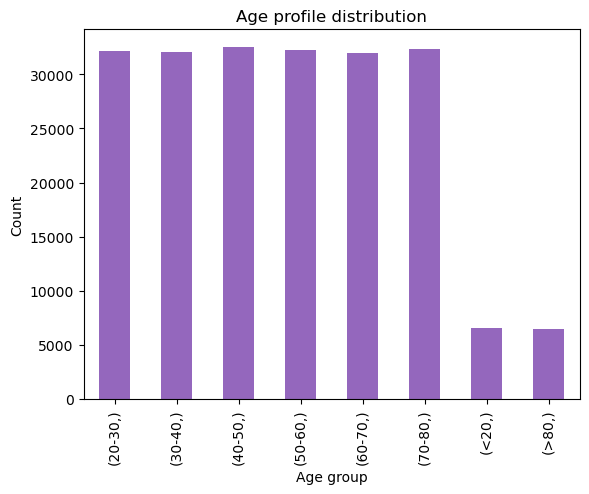

In [9]:
df_age_dist_plot = df_age_dist.value_counts().sort_index().plot.bar(color = 'tab:purple', xlabel = 'Age group', ylabel = 'Count', title = 'Age profile distribution')

In [10]:
# save the chart
df_age_dist_plot.figure.savefig(os.path.join(path, 'Analysis', 'Age_distribution.png'))

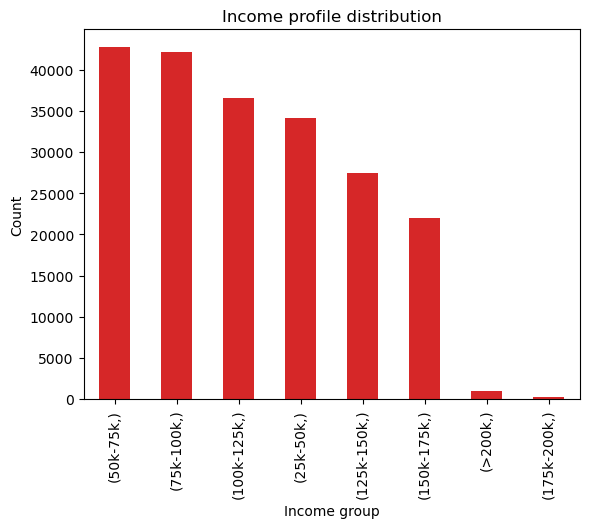

In [11]:
# visualization of income distribution
df_income_dist = df_merged.groupby('user_id').agg({'income_group':['max']})
df_income_dist_plot = df_income_dist.value_counts().plot.bar(color = 'tab:red', xlabel = 'Income group', ylabel = 'Count', title = 'Income profile distribution')

In [12]:
# save the chart
df_income_dist_plot.figure.savefig(os.path.join(path, 'Analysis', 'Income_distribution.png'))

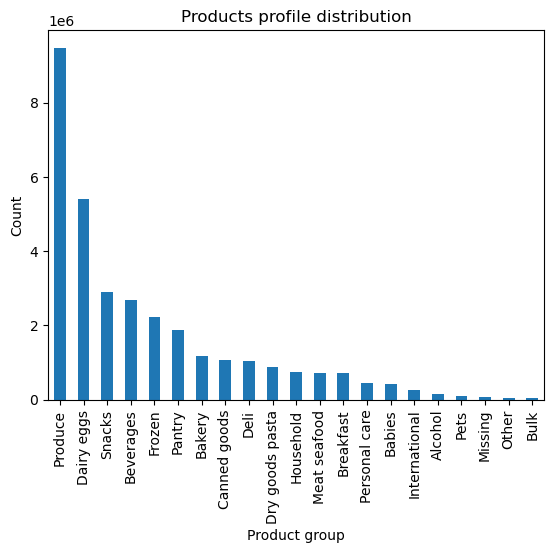

In [13]:
# Distribution of ordered Goods
df_goods_dist_plot = df_merged['goods_group'].value_counts().plot.bar(color = 'tab:blue', xlabel = 'Product group', ylabel = 'Count', title = 'Products profile distribution')

In [16]:
# Save the visualization
df_goods_dist_plot.figure.savefig(os.path.join(path, 'Analysis', 'Goods_distribution.jpg'))

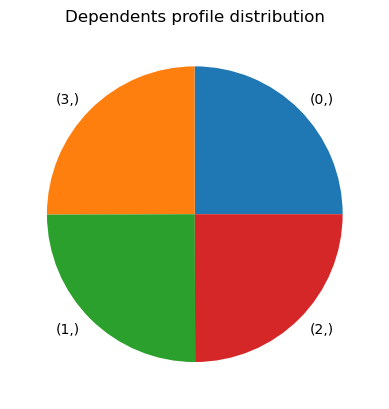

In [17]:
# visualization of distribution of # dependants
df_dependants_dist = df_merged.groupby('user_id').agg({'number_of_dependants':['max']})
df_dependants_dist_plot = df_dependants_dist.value_counts().plot.pie(title = 'Dependents profile distribution', ylabel='')

In [18]:
# Save the visualization
df_dependants_dist_plot.figure.savefig(os.path.join(path, 'Analysis', 'Dependants_distribution.png'))

# 7- Aggregate the max, mean, and min variables on a customer-profile level for usage frequency and expenditure

In [19]:
# age profile
df_merged.groupby('age_group').agg({'mean_order_price':['min', 'max','mean'],
                                    'order_frequency':['min', 'max','mean']})

mean_order_price                          order_frequency      \
                       min           max       mean             min max   
age_group                                                                 
20-30                  1.0  10209.987755  12.540052               0  30   
30-40                  1.0  12506.925000  11.933288               0  30   
40-50                  1.1  25005.425000  12.384515               0  30   
50-60                  1.0   6673.540000  11.862746               0  30   
60-70                  1.1   8703.400000  11.627890               0  30   
70-80                  1.0  14042.512281  12.158490               0  30   
<20                    1.3   1717.904274  10.342442               0  30   
>80                    2.0   3577.762500  10.472810               0  30   

                     
               mean  
age_group            
20-30      9.604687  
30-40      9.629635  
40-50      9.608545  
50-60      9.620322  
60-70      9.592169  
70-80      9.588746  
<20        9.615871  
>80        9.561893

In [20]:
# income profile
df_merged.groupby('income_group').agg({'mean_order_price':['min', 'max','mean'],
                                    'order_frequency':['min', 'max','mean']})

mean_order_price                           order_frequency      \
                          min           max        mean             min max   
income_group                                                                  
100k-125k            7.000000  12506.925000    9.923167               0  30   
125k-150k            7.000000  14042.512281   11.137401               0  30   
150k-175k            7.000000  15006.940000   14.075135               0  30   
175k-200k           29.468559  10209.987755  248.316061               0  30   
25k-50k              1.000000     13.878571    6.696985               0  30   
50k-75k              1.100000     22.256974    7.834932               0  30   
75k-100k             7.000000   7700.025641    9.075817               0  30   
>200k               24.103300  25005.425000  264.709601               0  30   

                         
                   mean  
income_group             
100k-125k      9.538483  
125k-150k      9.544887  
150k-175k      9.476129  
175k-200k      9.118300  
25k-50k       10.211944  
50k-75k        9.581778  
75k-100k       9.530128  
>200k          8.620508

In [21]:
# number of dependants profile
df_merged.groupby('number_of_dependants').agg({'mean_order_price':['min', 'max','mean'],
                                    'order_frequency':['min', 'max','mean']})

mean_order_price                           \
                                  min           max       mean   
number_of_dependants                                             
0                                 1.0  25005.425000  12.129243   
1                                 1.1  12506.925000  11.629316   
2                                 1.0  11772.100000  12.369543   
3                                 1.0  10209.987755  11.793264   

                     order_frequency                
                                 min max      mean  
number_of_dependants                                
0                                  0  30  9.576025  
1                                  0  30  9.616090  
2                                  0  30  9.623941  
3                                  0  30  9.608887

In [22]:
# family status profile
df_merged.groupby('family_status').agg({'mean_order_price':['min', 'max','mean'],
                                    'order_frequency':['min', 'max','mean']})

mean_order_price                           \
                                              min           max       mean   
family_status                                                                
divorced/widowed                              1.2  14042.512281  11.453674   
living with parents and siblings              1.3  10209.987755  10.828768   
married                                       1.0  12506.925000  12.005659   
single                                        1.0  25005.425000  12.480849   

                                 order_frequency                
                                             min max      mean  
family_status                                                   
divorced/widowed                               0  30  9.530886  
living with parents and siblings               0  30  9.537978  
married                                        0  30  9.621629  
single                                         0  30  9.599519

# Compare customer profiles with regions and departments

In [23]:
# region and age groups
xtab_age_region = pd.crosstab(df_merged['region'], df_merged['age_group'], dropna=False)

In [24]:
xtab_age_region

age_group,20-30,30-40,40-50,50-60,60-70,70-80,<20,>80
region,,,,,,,,
Midwest_region,1194044,1180424,1227062,1199596,1161370,1164023,226661,244145
Northeast_region,886304,888917,900208,890071,884533,909575,184133,178995
South_region,1708540,1723110,1677004,1653555,1664412,1696401,344093,324770
West_region,1281473,1281300,1304963,1320953,1276949,1285462,265193,276620


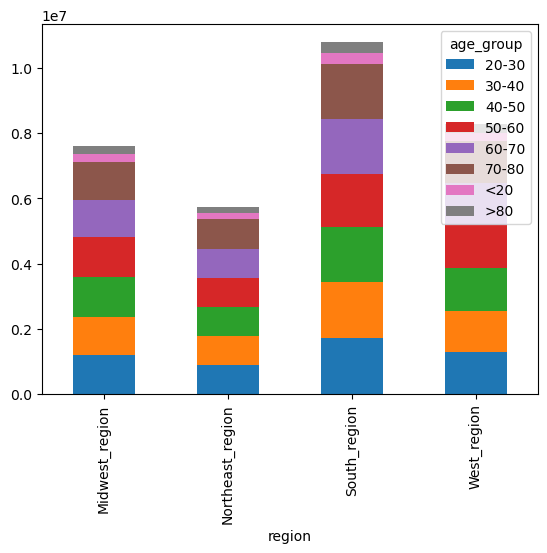

In [25]:
xtab_age_region_plot = xtab_age_region.plot(kind = 'bar', stacked = True)

In [27]:
# save the plot
xtab_age_region_plot.figure.savefig(os.path.join(path, 'Analysis', 'age_region.png'))

In [28]:
# region and family status
xtab_famstat_region = pd.crosstab(df_merged['region'], df_merged['family_status'], dropna=False)
xtab_famstat_region

family_status,divorced/widowed,living with parents and siblings,married,single
region,,,,
Midwest_region,646401,366517,5325608,1258799
Northeast_region,501059,268114,4036321,917242
South_region,920849,529584,7560642,1780810
West_region,703503,386388,5834182,1368840


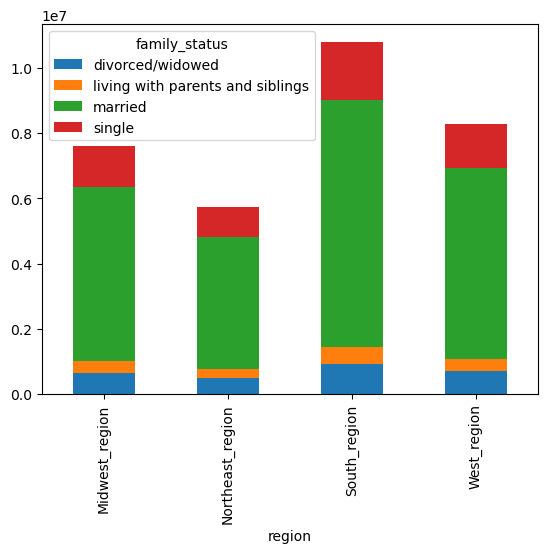

In [29]:
xtab_famstat_region_plot = xtab_famstat_region.plot(kind = 'bar', stacked = True)

In [30]:
# save the plot
xtab_famstat_region_plot.figure.savefig(os.path.join(path, 'Analysis', 'familystatus_region.png'))

In [31]:
# region and income groups
xtab_income_region = pd.crosstab(df_merged['region'], df_merged['income_group'], dropna=False)
xtab_income_region

income_group,100k-125k,125k-150k,150k-175k,175k-200k,25k-50k,50k-75k,75k-100k,>200k
region,,,,,,,,
Midwest_region,1486246,1097748,878801,11850,838398,1589484,1629501,65297
Northeast_region,1089191,832496,658146,7515,627256,1194893,1272112,41127
South_region,2029480,1494151,1239215,18151,1219460,2273515,2433067,84846
West_region,1578892,1154981,968075,11385,908969,1790791,1812647,67173


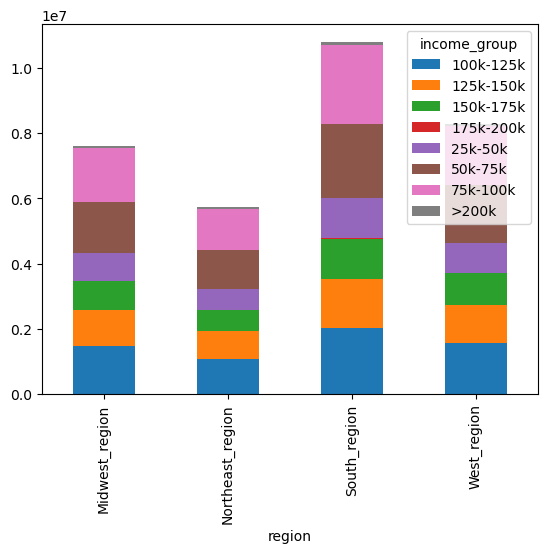

In [32]:
xtab_income_region_plot = xtab_income_region.plot(kind = 'bar', stacked = True)

In [34]:
# save the plot
xtab_income_region_plot.figure.savefig(os.path.join(path, 'Analysis', 'income_region.png'))

In [35]:
# region and number of dependants
xtab_dependants_region = pd.crosstab(df_merged['region'], df_merged['number_of_dependants'], dropna=False)
xtab_dependants_region

number_of_dependants,0,1,2,3
region,,,,
Midwest_region,1905200,1926472,1890986,1874667
Northeast_region,1418301,1442253,1417102,1445080
South_region,2701659,2659730,2723958,2706538
West_region,2072343,2052649,2059097,2108824


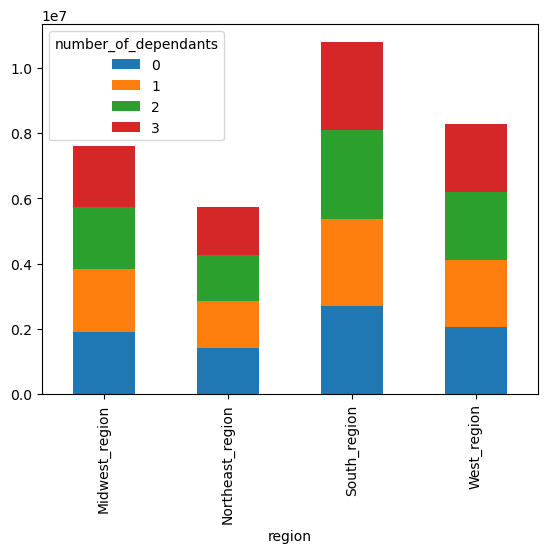

In [36]:
xtab_dependants_region_plot = xtab_dependants_region.plot(kind = 'bar', stacked = True)

In [37]:
# save the plot
xtab_dependants_region_plot.figure.savefig(os.path.join(path, 'Analysis', 'dependants_region.png'))

In [38]:
# depertment and age groups
xtab_age_department = pd.crosstab(df_merged['goods_group'], df_merged['age_group'], dropna=False)

In [39]:
xtab_age_department

age_group,20-30,30-40,40-50,50-60,60-70,70-80,<20,>80
goods_group,,,,,,,,
Alcohol,23456,25118,23973,24170,22837,23848,6315,3979
Babies,66940,65909,69248,65269,64885,64886,13524,13141
Bakery,184252,183863,184533,183655,180137,182712,36105,37171
Beverages,416102,414617,425165,425090,412810,426140,83441,84758
Breakfast,111997,108948,111180,109714,106557,109615,22297,22725
Bulk,5507,5396,5581,5187,5368,5220,1099,1215
Canned goods,169202,166296,167484,167598,165143,165186,33740,33409
Dairy eggs,847708,852077,854998,835589,823787,845690,170293,168605
Deli,164682,164566,165955,163792,162935,163600,32752,32967


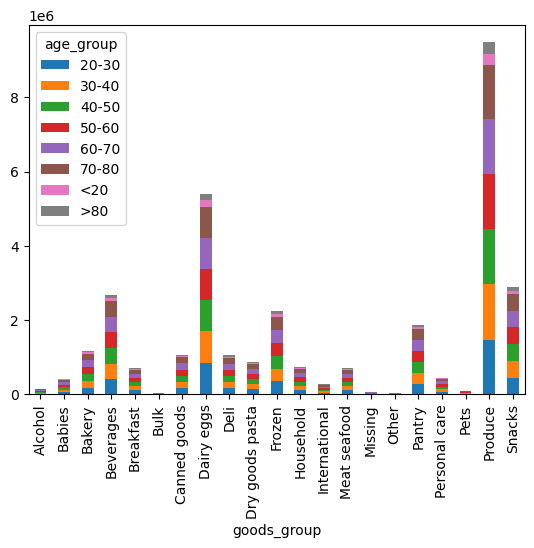

In [40]:
xtab_age_department_plot = xtab_age_department.plot(kind='bar', stacked=True)

In [41]:
# save the plot
xtab_age_department_plot.figure.savefig(os.path.join(path, 'Analysis', 'age_department.png'))

In [42]:
# department and family status
xtab_famstat_department = pd.crosstab(df_merged['goods_group'], df_merged['family_status'], dropna=False)
xtab_famstat_department

family_status,divorced/widowed,living with parents and siblings,married,single
goods_group,,,,
Alcohol,12615,8896,105682,26503
Babies,35326,20146,297162,71168
Bakery,100401,56142,821881,194004
Beverages,231025,124629,1889052,443417
Breakfast,59498,34731,493725,115079
Bulk,2765,1674,24621,5513
Canned goods,89259,51190,752030,175579
Dairy eggs,461911,260787,3788598,887451
Deli,90818,50415,735689,174327


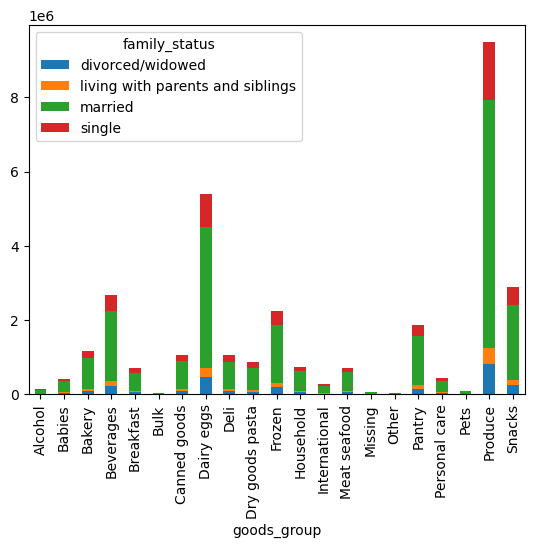

In [43]:
xtab_famstat_department_plot = xtab_famstat_department.plot(kind='bar', stacked=True)

In [44]:
# save the plot
xtab_famstat_department_plot.figure.savefig(os.path.join(path, 'Analysis', 'familystatus_department.png'))

In [45]:
# department and income groups
xtab_income_department = pd.crosstab(df_merged['goods_group'], df_merged['income_group'], dropna=False)
xtab_income_department

income_group,100k-125k,125k-150k,150k-175k,175k-200k,25k-50k,50k-75k,75k-100k,>200k
goods_group,,,,,,,,
Alcohol,27632,20145,17322,1431,19808,28372,32786,6200
Babies,85148,62758,51984,299,30858,88680,101925,2150
Bakery,227016,168456,138721,2538,114709,245623,262570,12795
Beverages,485877,362434,296189,4000,405505,552530,556630,24958
Breakfast,129018,94758,79130,1106,97368,148423,146609,6621
Bulk,6373,4545,3744,2,4889,7480,7513,27
Canned goods,211666,159166,127720,1746,86652,228154,243662,9292
Dairy eggs,1041577,776149,630428,8891,535079,1144985,1216616,45022
Deli,202520,148594,122063,1518,114096,222211,232826,7421


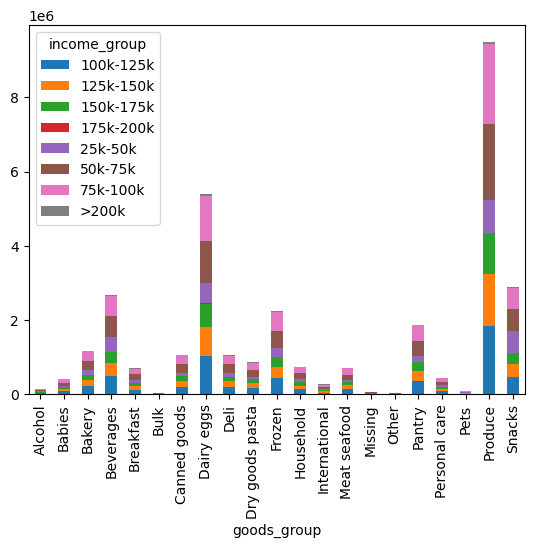

In [46]:
xtab_income_department_plot = xtab_income_department.plot(kind='bar', stacked=True)

In [47]:
# save the plot
xtab_income_department_plot.figure.savefig(os.path.join(path, 'Analysis', 'income_department.png'))

In [48]:
# department and number of dependants
xtab_dependants_department = pd.crosstab(df_merged['goods_group'], df_merged['number_of_dependants'], dropna=False)
xtab_dependants_department

number_of_dependants,0,1,2,3
goods_group,,,,
Alcohol,39118,37964,36878,39736
Babies,106494,103239,107975,106094
Bakery,294405,292993,292171,292859
Beverages,674442,668226,675392,670063
Breakfast,174577,177209,175781,175466
Bulk,8278,8848,8762,8685
Canned goods,264838,267129,266477,269614
Dairy eggs,1349362,1353489,1343988,1351908
Deli,265145,259567,262007,264530


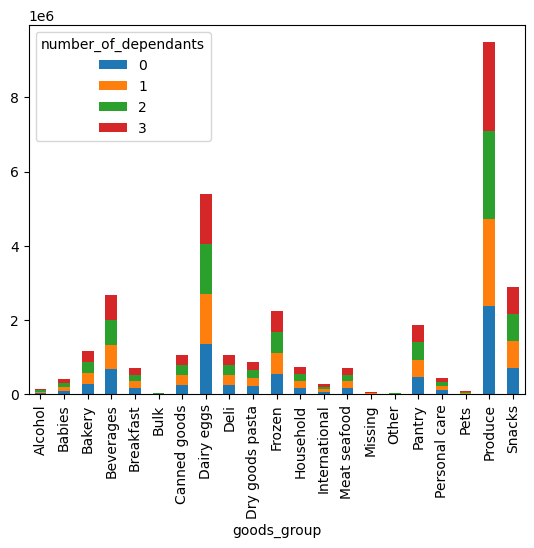

In [49]:
xtab_dependants_department_plot = xtab_dependants_department.plot(kind='bar', stacked=True)

In [50]:
# save the plot
xtab_dependants_department_plot.figure.savefig(os.path.join(path, 'Analysis', 'dependants_department.png'))